In [4]:
from pathlib import Path
from sklearn.model_selection import KFold
import shutil
from ultralytics import YOLO
import pandas as pd
import os

In [5]:
import torch
torch.backends.cudnn.benchmark = True


En este notebook realizamos el finetuning del mejor modelo obtenido despues de haber hecho busuqeuda de hiperparametros y haberlo entrenando durante 48 epocas (40 min por epoca en una RTX 4090 de 24 GB, aproximadamente 32h), queriamos entrenarlo por 100 epocas pero el tiempo fue limitado dado el error de la aumentacion de los resultados anteriores. Como ahora el modelo si funciona bien, vamos a revisar si podemos mejorarlo.

## Resultados sin fine tuning

In [ ]:
import torch
import gc

def limpiar_memoria_gpu():
    """Limpia la memoria GPU antes de reintentar"""
    print("🧹 Limpiando memoria GPU...")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    
    gc.collect()
    
    if torch.cuda.is_available():
        memory_allocated = torch.cuda.memory_allocated(0) / 1024**3
        memory_reserved = torch.cuda.memory_reserved(0) / 1024**3
        print(f"   📊 GPU Memory allocated: {memory_allocated:.2f} GB")
        print(f"   📊 GPU Memory reserved: {memory_reserved:.2f} GB")
    
    print("✅ Memoria limpiada")

# Limpiar memoria
limpiar_memoria_gpu()

🧹 Limpiando memoria GPU...
   📊 GPU Memory allocated: 0.00 GB
   📊 GPU Memory reserved: 0.00 GB
✅ Memoria limpiada


## Resultados Entrenamiento

Si priorizamos la precision sobre el recall, podriamos tener un modelo que detecte zonas de mineria ilegual unicamente cuando esta muy seguro, y esto nos podria dejar muchas zonas ilegales sin detectar. Por esto nos centrarermos en el recall.

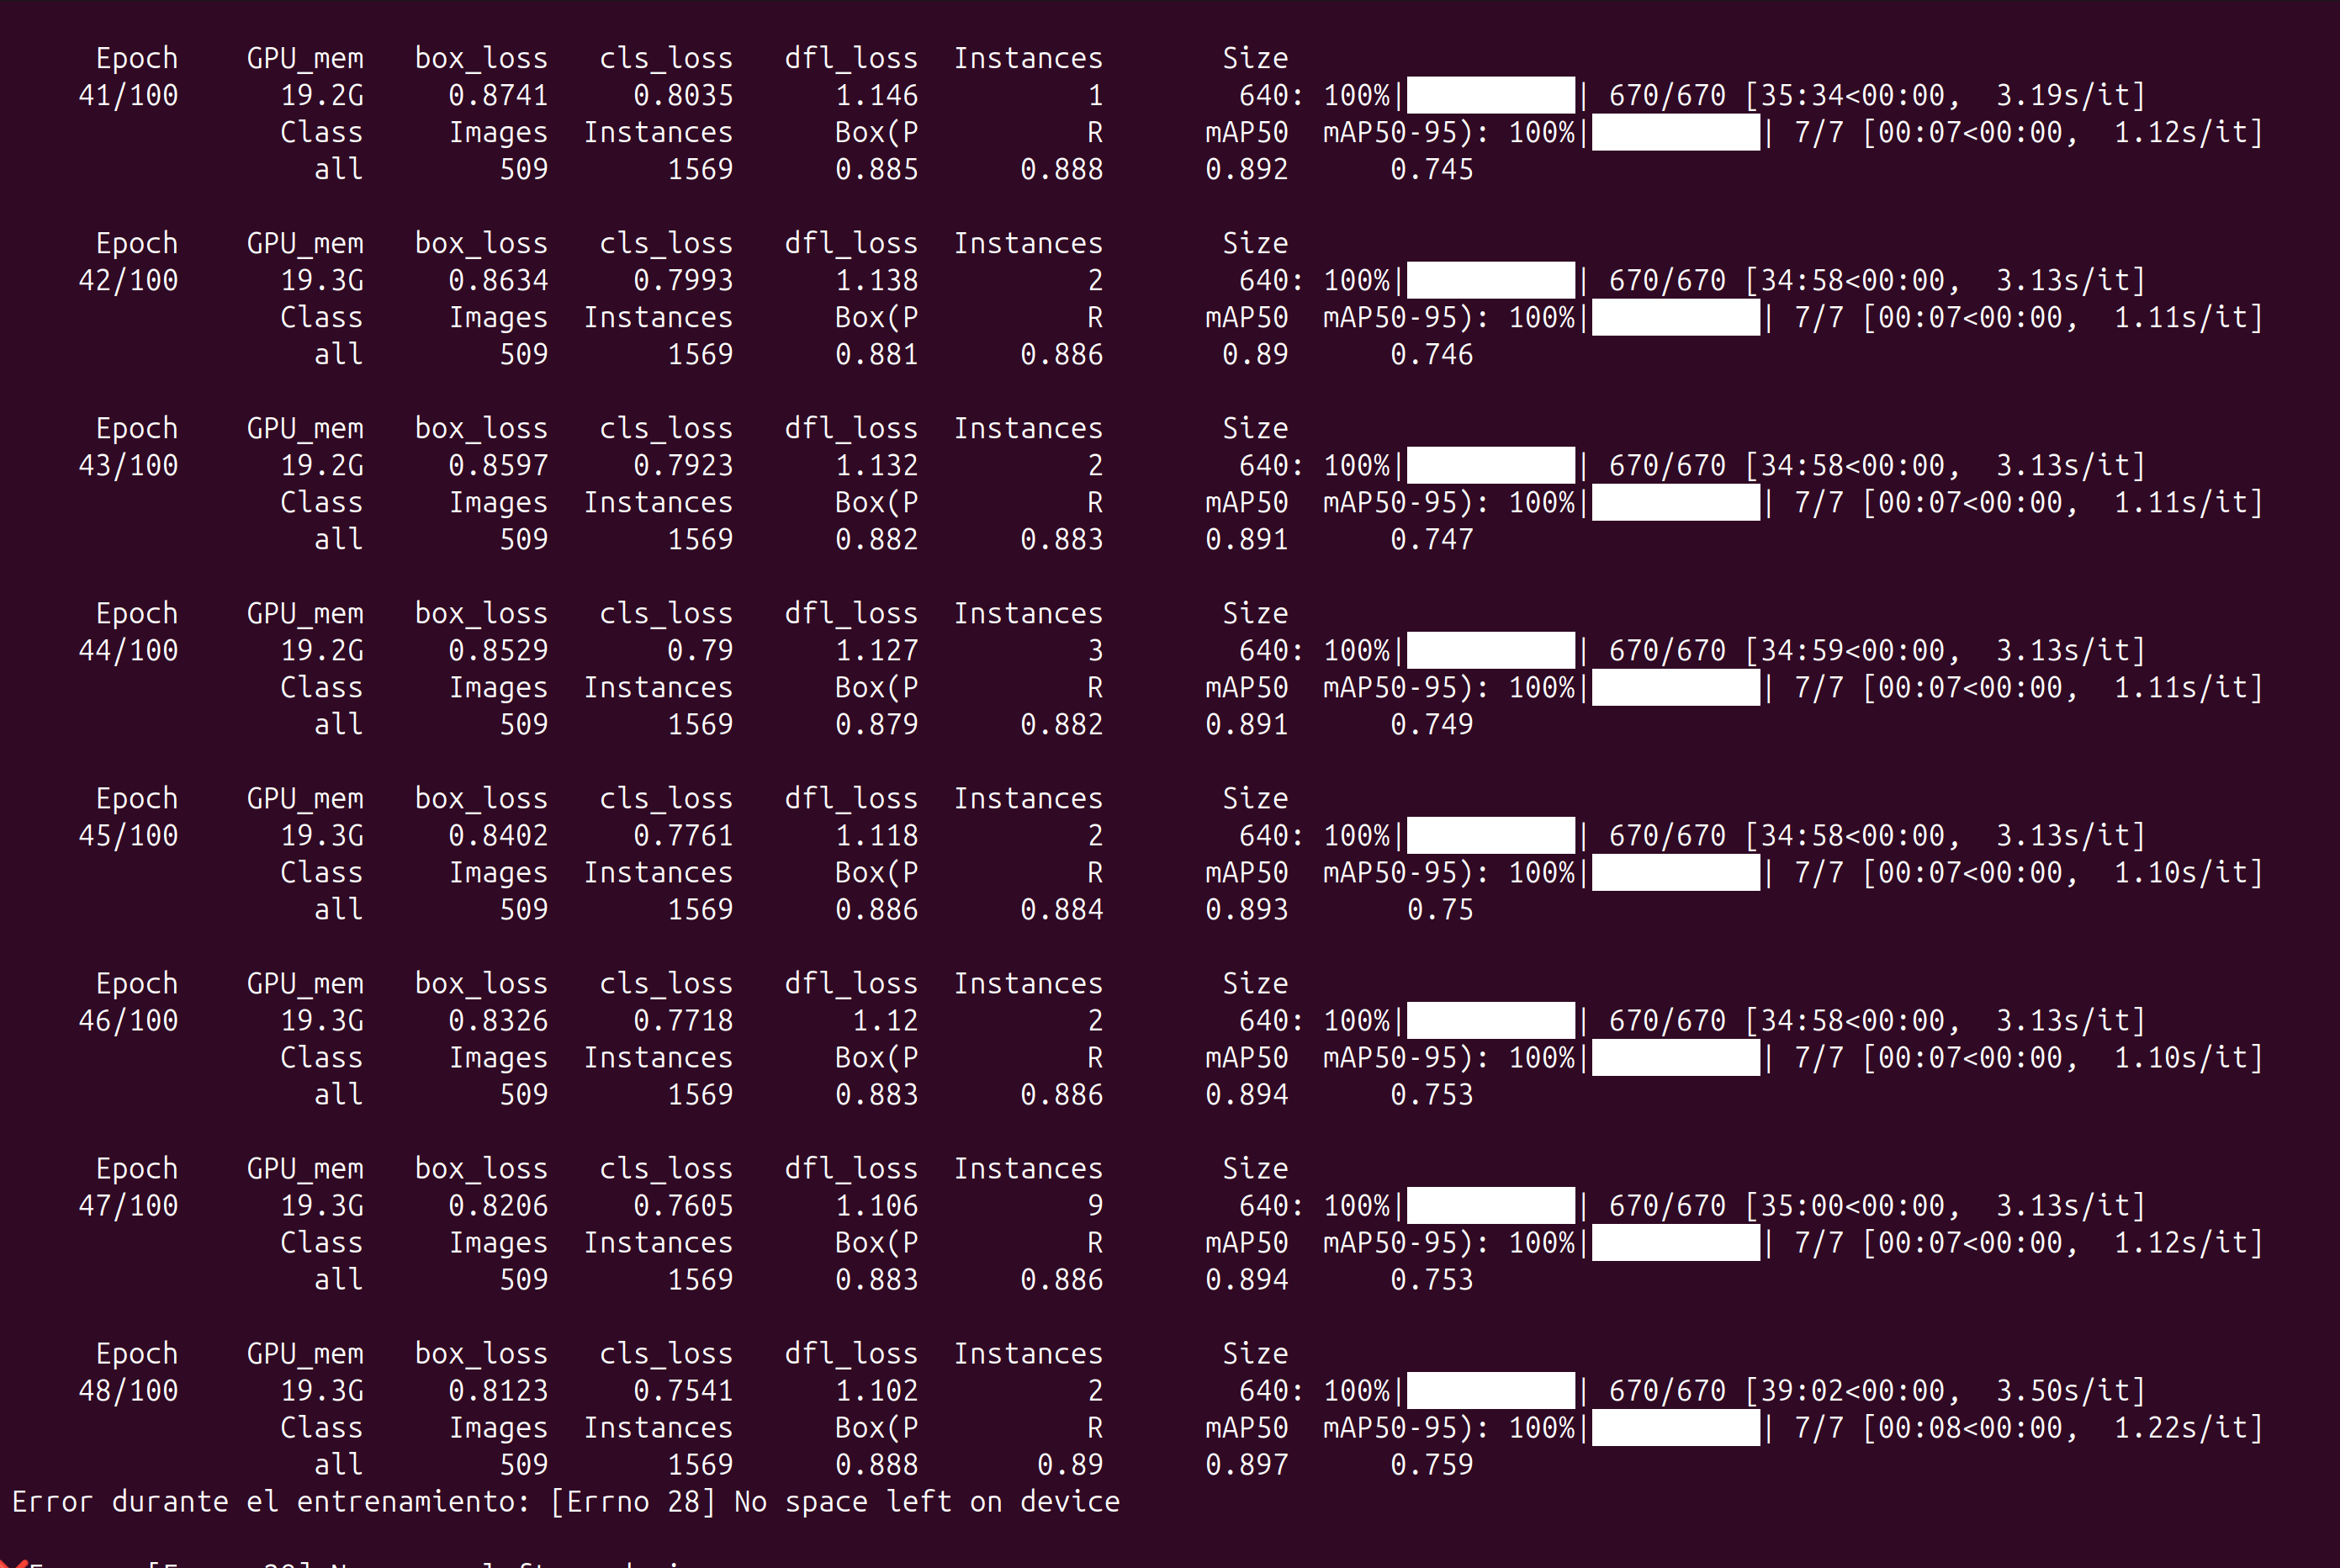

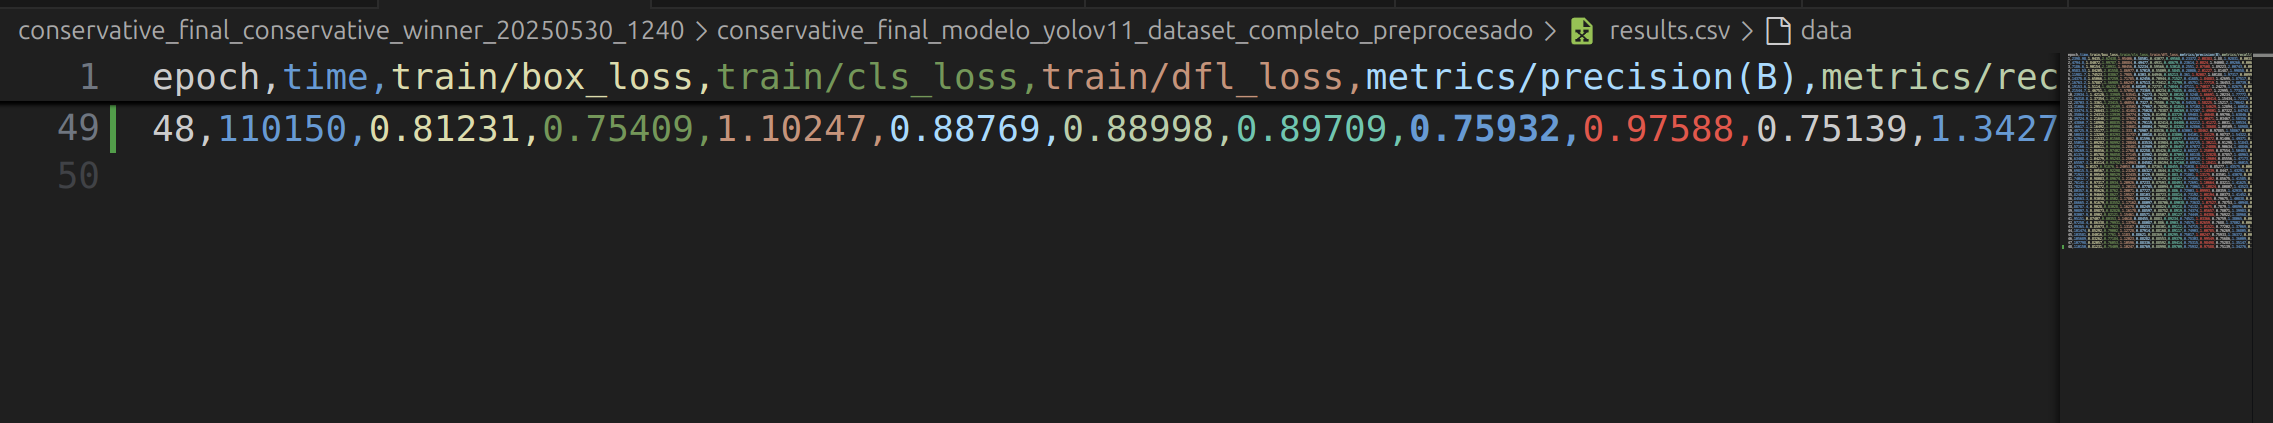

# Finetuning

In [2]:
import os


def finetune_yolo_model(
    model_path,
    dataset_yaml_path,
    save_dir,
    run_name,
    lr=0.0005,
    epochs=15,
    imgsz=640,
    batch=40,
):
    """
    Fine-tunes only the detection head of a YOLOv8 model (freezing the backbone).
    
    Args:
        model_path (str): Path to the pre-trained YOLO model (.pt).
        dataset_yaml_path (str): Path to the dataset YAML file.
        save_dir (str): Base directory to save the run.
        run_name (str): Name of the training run.
        lr (float): Initial learning rate (suggested: 1e-4 to 1e-3).
        epochs (int): Number of fine-tuning epochs.
        imgsz (int): Image size for training.
        batch (int): Batch size.
        device (int or str): Device to use ('cpu', 0, 1, etc.).
    """
    assert os.path.exists(model_path), f"Modelo no encontrado: {model_path}"
    assert os.path.exists(dataset_yaml_path), f"YAML no encontrado: {dataset_yaml_path}"
    
    model = YOLO(model_path)

    model.train(
        data=dataset_yaml_path,
        epochs=epochs,
        patience=3,
        lr0=lr,
        imgsz=imgsz,
        batch=batch,
        project=save_dir,
        name=run_name,
        optimizer="Adam",          
        cos_lr=True,             
        verbose=True,
        seed=42,
        deterministic=True,
        single_cls=False,
        rect=False,
        freeze=10                
    )


## Finetuning - completo preprocesado

In [7]:
finetune_yolo_model(
    model_path="./conservative_final_conservative_winner_20250530_1240/conservative_final_modelo_yolov11_dataset_completo_preprocesado/weights/best.pt",
    dataset_yaml_path="./preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="finetuning_preprocessed_model",
)

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24184MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=40, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=./preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=./conservative_final_conservative_winner_20250530_1240/conservative_final_modelo_yolov11_dataset_completo_preprocesado/weights/best.pt, momentum=0.937, mos

train: Scanning /home/aia-workstation/Desktop/FLIR_GPF2/preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/train/labels.cache... 26762 images, 2957 backgrounds, 1 corrupt: 100%|██████████| 26762/26762 [00:00<?, ?it/s]

train: /home/aia-workstation/Desktop/FLIR_GPF2/preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/train/images/frame_0234.jpg: ignoring corrupt image/label: negative label values [-1.]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2579.0±1631.0 MB/s, size: 432.2 KB)


val: Scanning /home/aia-workstation/Desktop/FLIR_GPF2/preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/val/labels.cache... 511 images, 66 backgrounds, 2 corrupt: 100%|██████████| 511/511 [00:00<?, ?it/s]

val: /home/aia-workstation/Desktop/FLIR_GPF2/preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/val/images/frame_0089.jpg: ignoring corrupt image/label: negative label values [-1. -1. -1.]
val: /home/aia-workstation/Desktop/FLIR_GPF2/preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/val/images/frame_0222.jpg: ignoring corrupt image/label: negative label values [-1. -1. -1.]


Plotting labels to finetuning_resultados/finetuning_preprocessed_model2/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.000625), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados/finetuning_preprocessed_model2
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      8.55G     0.7181     0.6972       1.06          2        640: 100%|██████████| 670/670 [24:01<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        509       1569      0.869      0.884      0.891      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      9.48G     0.7627     0.7325      1.085          5        640: 100%|██████████| 670/670 [24:08<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]

                   all        509       1569      0.865      0.881      0.896      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      9.48G     0.7851     0.7546      1.103          1        640: 100%|██████████| 670/670 [24:03<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]

                   all        509       1569       0.85      0.888      0.888      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      9.53G     0.7564     0.7247       1.09          2        640: 100%|██████████| 670/670 [23:57<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        509       1569      0.862      0.879      0.899       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      9.53G     0.7372     0.7131      1.079          5        640: 100%|██████████| 670/670 [23:56<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        509       1569      0.871      0.881       0.91       0.74


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      9.54G     0.6375     0.6111      1.012          0        640: 100%|██████████| 670/670 [23:50<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]

                   all        509       1569      0.878      0.892      0.911      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      9.54G     0.6081     0.5845     0.9954          0        640: 100%|██████████| 670/670 [23:48<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        509       1569      0.888      0.896      0.921      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      9.54G     0.5763     0.5658     0.9741          1        640: 100%|██████████| 670/670 [23:48<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        509       1569      0.891      0.899      0.917      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      9.54G     0.5394     0.5407     0.9547          2        640: 100%|██████████| 670/670 [23:48<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

                   all        509       1569      0.875        0.9      0.911      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      9.54G     0.5095     0.5188     0.9388          2        640: 100%|██████████| 670/670 [23:49<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        509       1569      0.915      0.902      0.927      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      9.54G     0.4817      0.502     0.9252          1        640: 100%|██████████| 670/670 [23:48<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        509       1569        0.9      0.906      0.924      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      9.54G     0.4576     0.4849     0.9109          2        640: 100%|██████████| 670/670 [23:49<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        509       1569      0.908      0.905      0.931      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      9.54G     0.4338     0.4724     0.9018          7        640: 100%|██████████| 670/670 [23:48<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        509       1569      0.916      0.906      0.931      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      9.54G     0.4181     0.4588      0.896          2        640: 100%|██████████| 670/670 [23:47<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

                   all        509       1569      0.914      0.909      0.935      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      9.54G     0.4071     0.4509     0.8906          1        640: 100%|██████████| 670/670 [23:51<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        509       1569      0.911      0.909      0.935      0.813



15 epochs completed in 6.013 hours.
Optimizer stripped from finetuning_resultados/finetuning_preprocessed_model2/weights/last.pt, 40.5MB
Optimizer stripped from finetuning_resultados/finetuning_preprocessed_model2/weights/best.pt, 40.5MB

Validating finetuning_resultados/finetuning_preprocessed_model2/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24184MiB)
YOLO11m summary (fused): 125 layers, 20,033,887 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


                   all        509       1569      0.914      0.908      0.934      0.815
             Vehiculos         22         23      0.931          1      0.995      0.986
               Bodegas        249        897      0.935      0.871      0.949      0.703
               Caminos        245        400      0.947      0.955      0.958      0.848
                  Rios        114        169      0.892      0.911      0.926      0.798
Zonas de mineria ilegal         65         80      0.865      0.803      0.844       0.74
Speed: 1.1ms preprocess, 13.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to finetuning_resultados/finetuning_preprocessed_model2


# Resultados Finetuning

## Completo

### Preprocesamiento

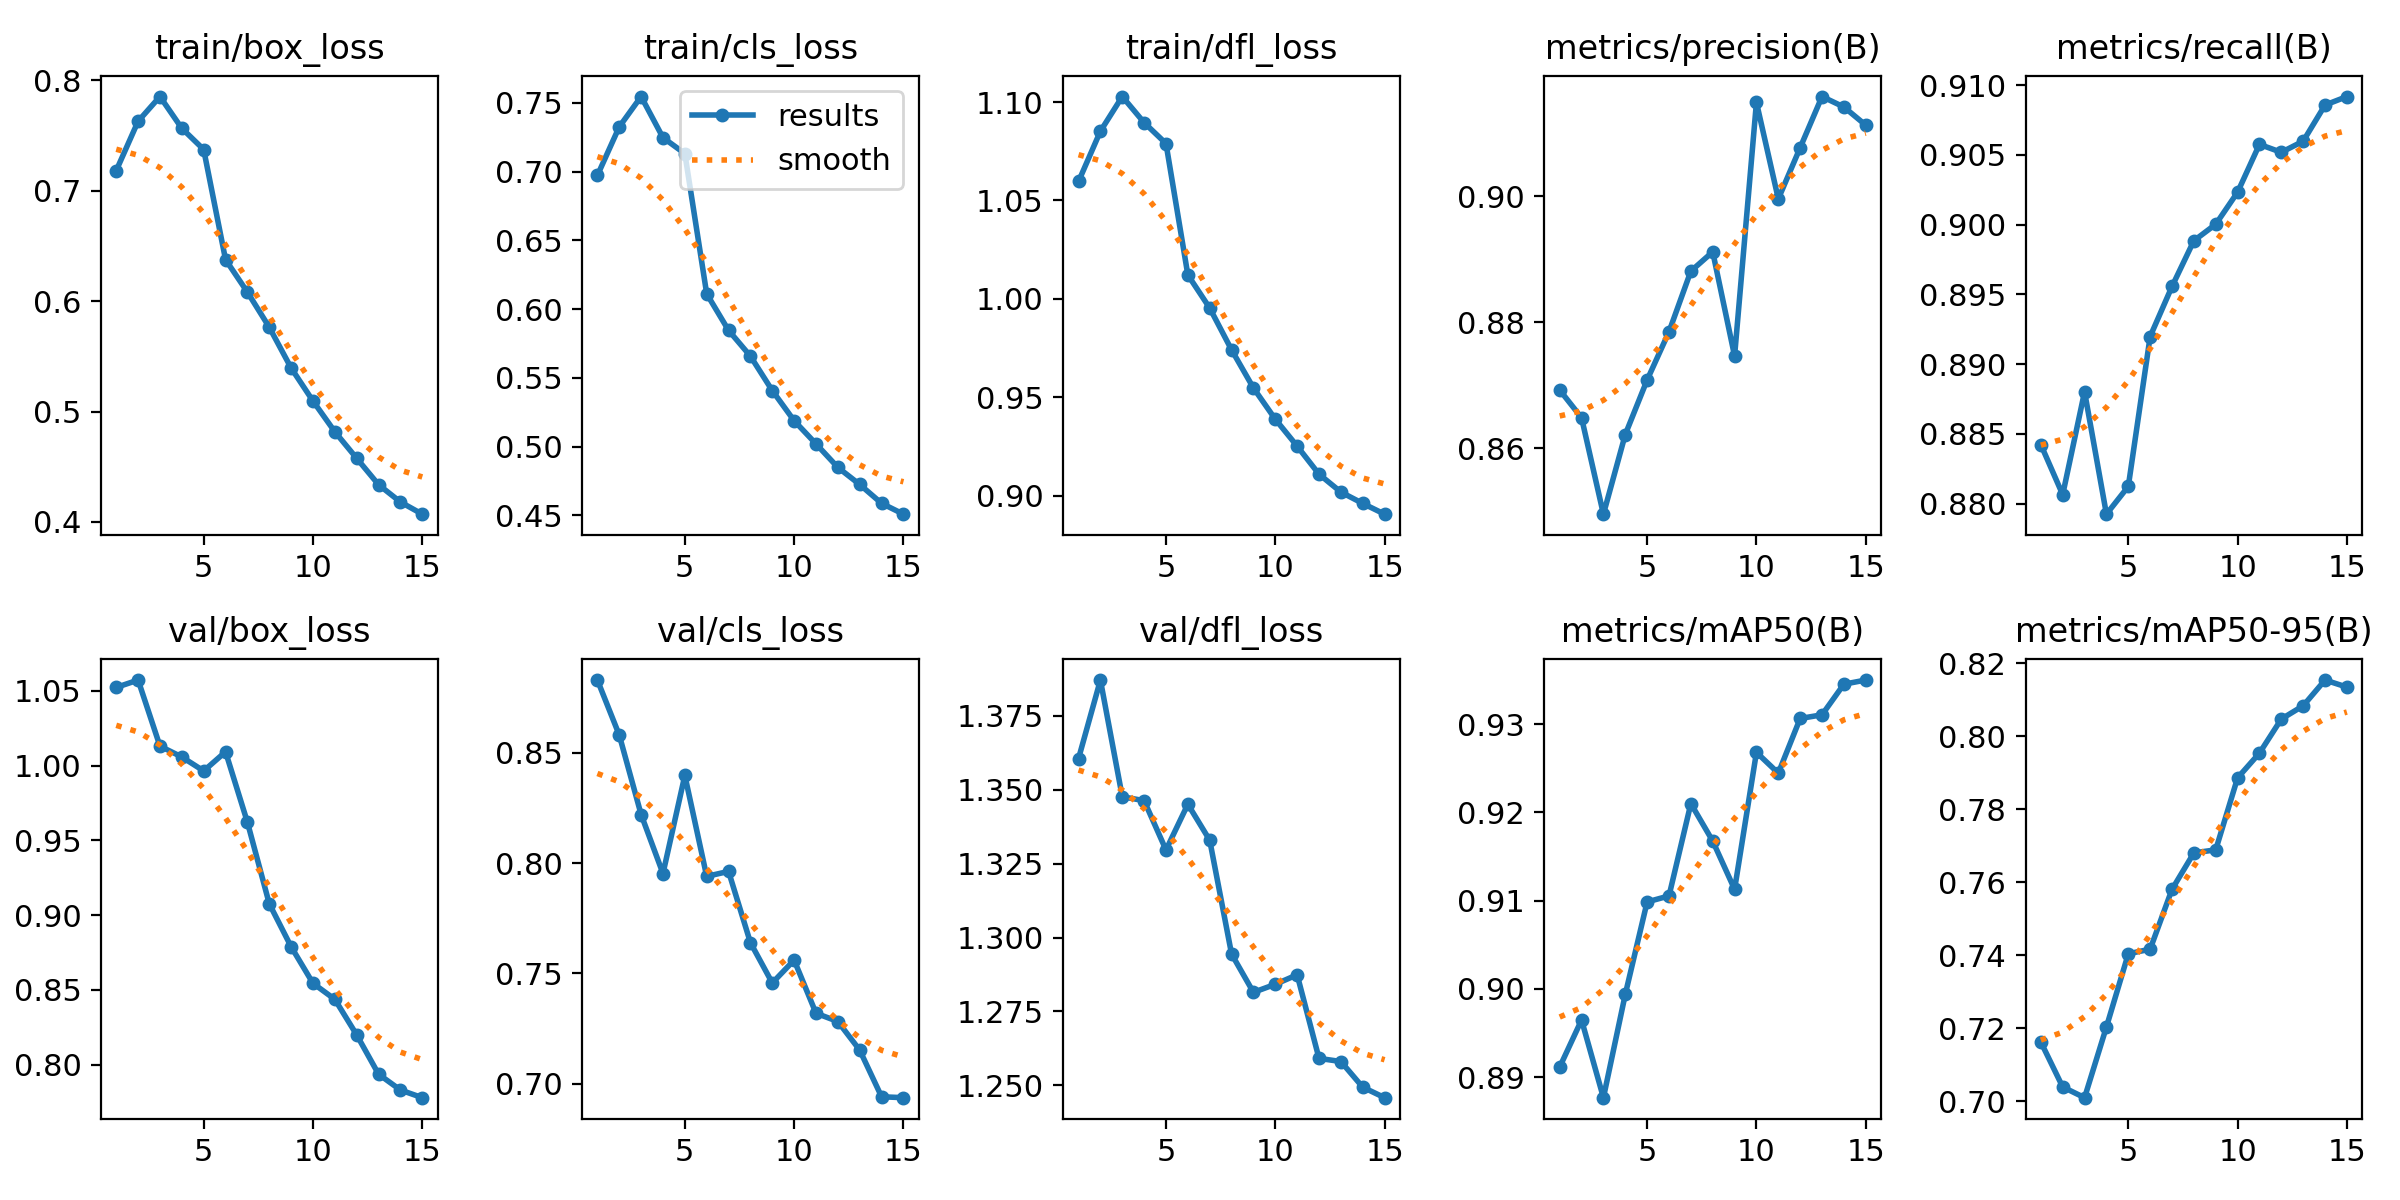

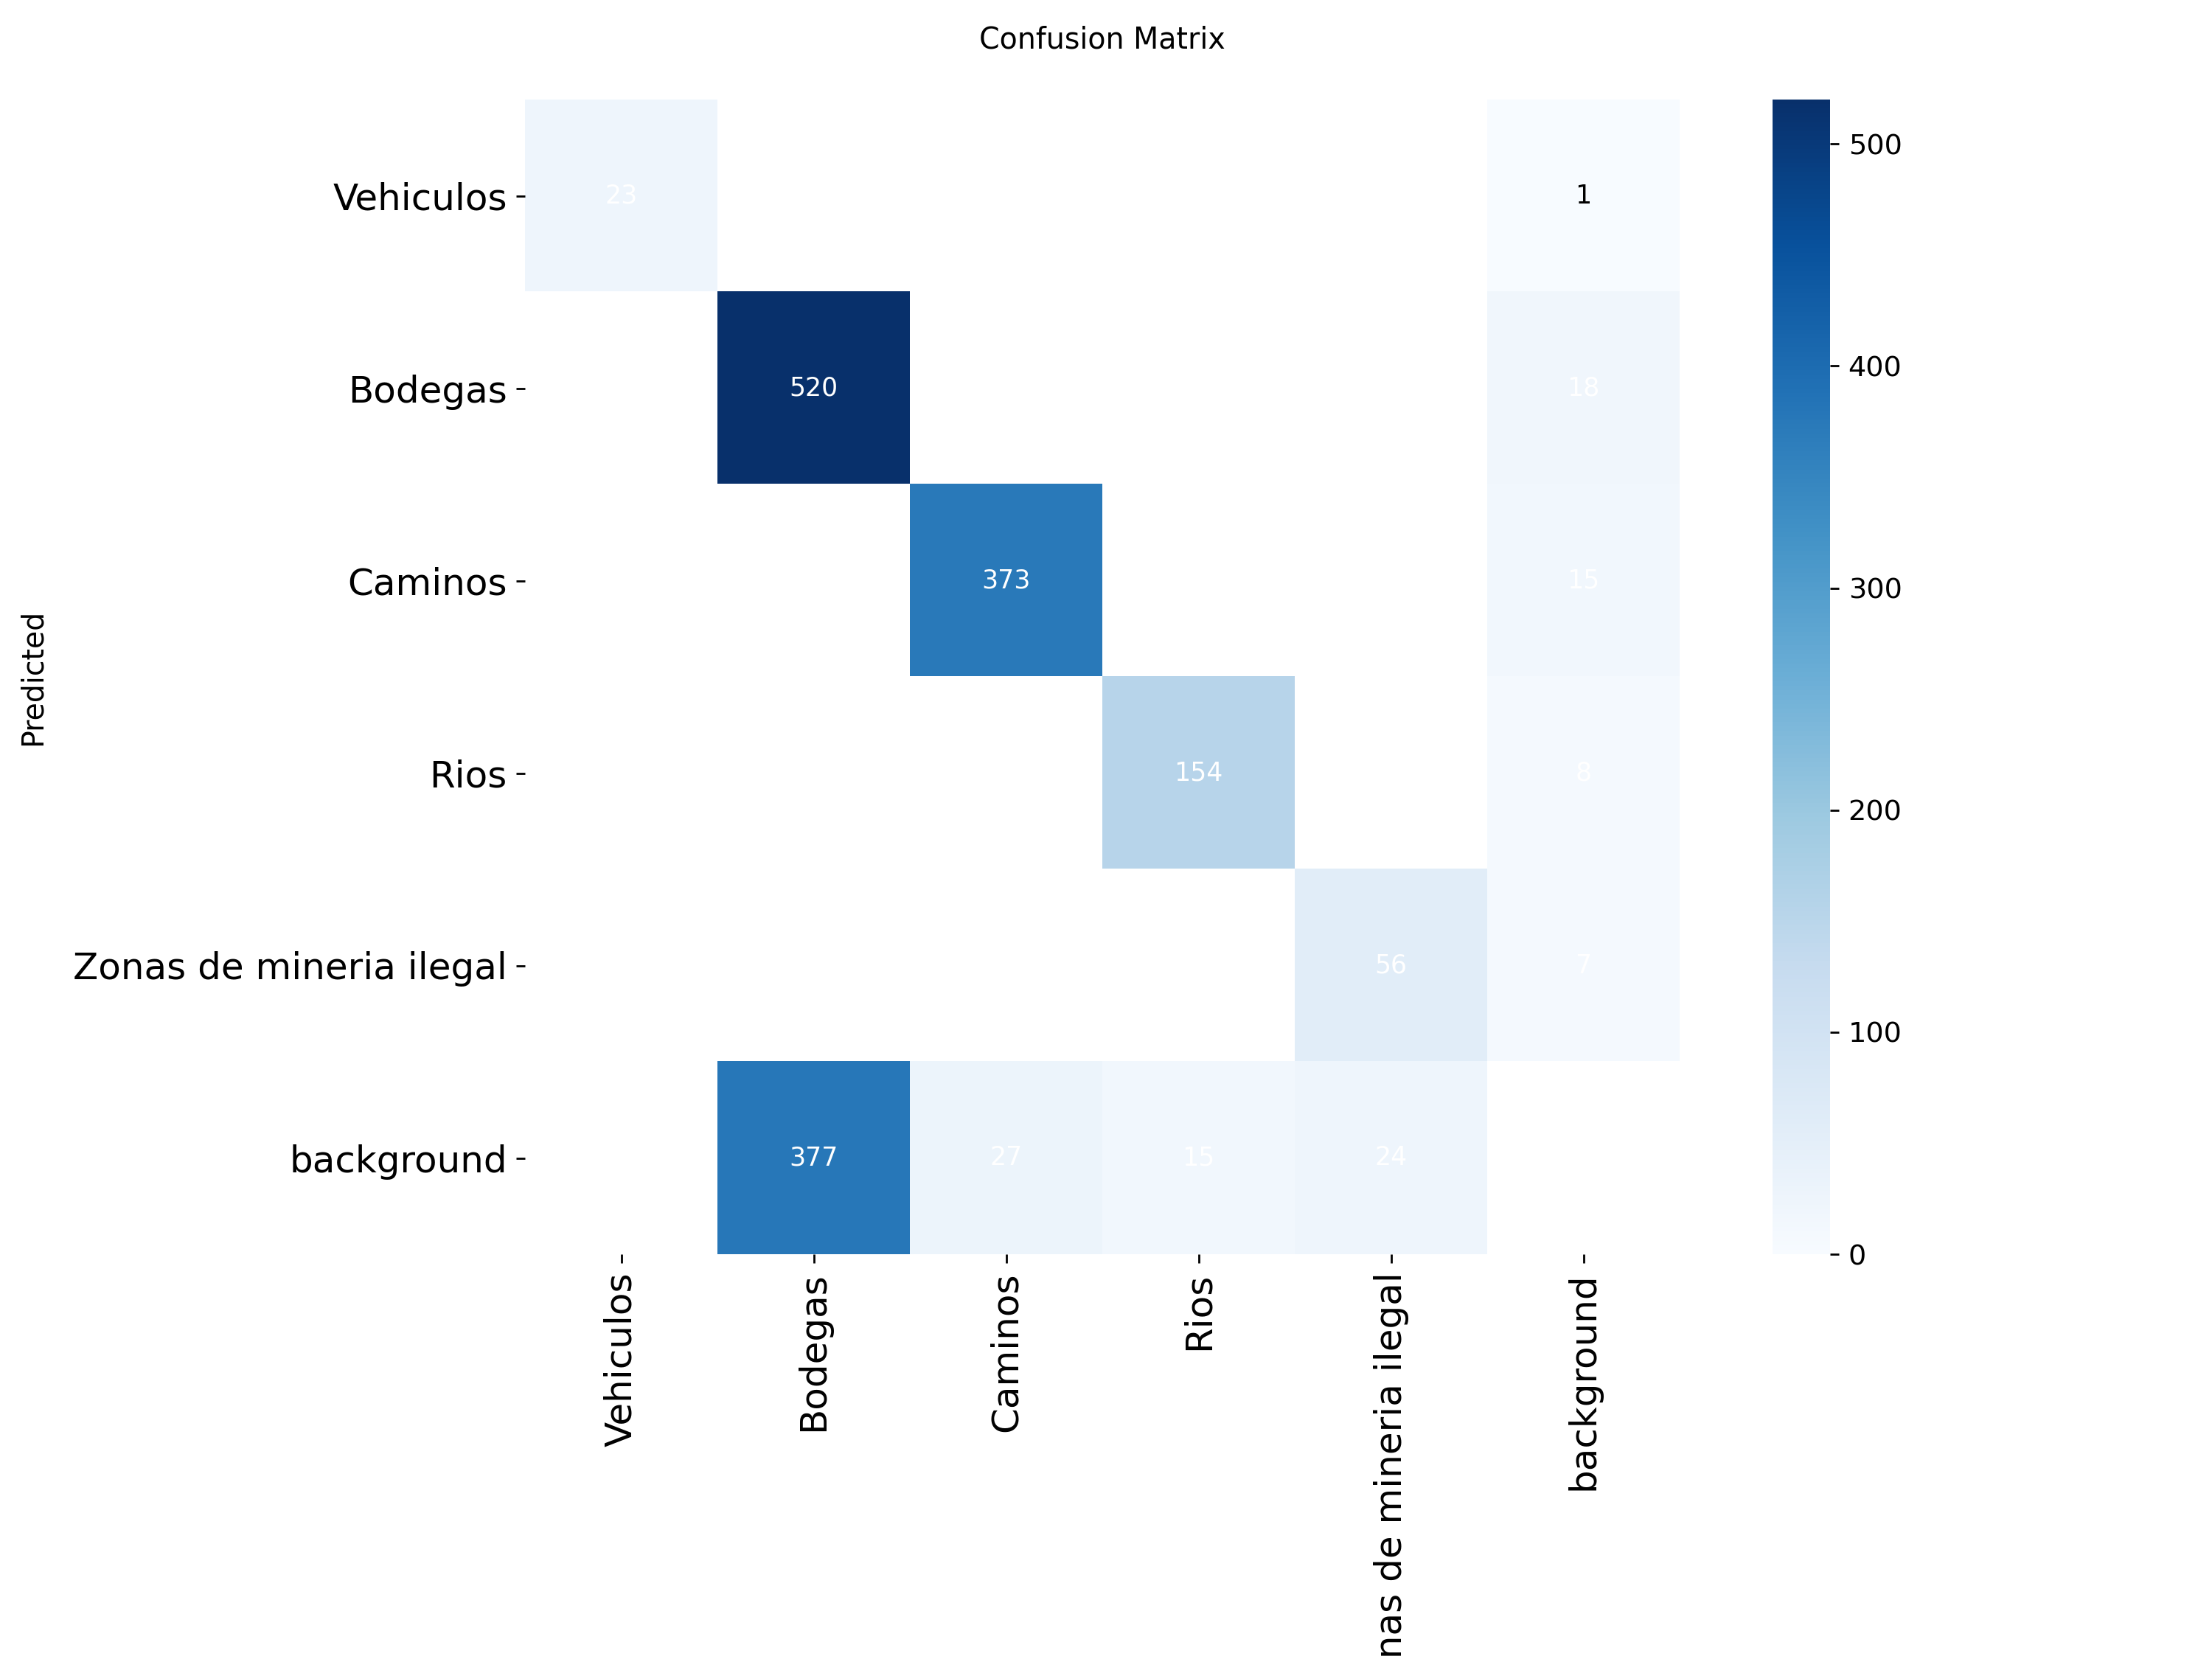

In [10]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/finetuning_preprocessed_model2/results.png'))

display(PImage.open('finetuning_resultados/finetuning_preprocessed_model2/confusion_matrix.png'))

# Metricas

In [11]:
def evaluate_yolo_model_by_class(model_path, dataset_yaml_path, class_idx=4, class_name=None, split='test', imgsz=640, device=0):
    from ultralytics import YOLO
    import os
    import torch

    assert os.path.exists(model_path), f"Modelo no encontrado: {model_path}"
    assert os.path.exists(dataset_yaml_path), f"YAML no encontrado: {dataset_yaml_path}"

    model = YOLO(model_path)

    metrics = model.val(
        data=dataset_yaml_path,
        split=split,
        imgsz=imgsz,
        device=device,
        iou=0.5,
        verbose=True
    )

    # Métricas generales
    overall_metrics = {
        'precision_all': metrics.box.p.mean().item(),
        'recall_all': metrics.box.r.mean().item(),
        'mAP50_all': metrics.box.map50.mean().item(),
        'mAP50-95_all': metrics.box.map.mean().item()
    }

    # Verifica si las métricas son por clase (tensores) o escalares
    try:
        p_cls = metrics.box.p[class_idx].item()
        r_cls = metrics.box.r[class_idx].item()
        map50_cls = metrics.box.map50[class_idx].item()
        map_cls = metrics.box.map[class_idx].item()

        class_metrics = {
            'precision': p_cls,
            'recall': r_cls,
            'mAP50': map50_cls,
            'mAP50-95': map_cls
        }

        print(f"\n🔎 Métricas para la clase '{class_name or class_idx}' en modelo '{os.path.basename(model_path)}':")
        for k, v in class_metrics.items():
            print(f"{k}: {v:.4f}")

    except (IndexError, TypeError):
        print(f"\n El modelo '{os.path.basename(model_path)}' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)")
        class_metrics = {
            'precision': None,
            'recall': None,
            'mAP50': None,
            'mAP50-95': None
        }

    return overall_metrics, class_metrics


In [12]:
# Lista de modelos (ruta, yaml, nombre)
models_info = [
    # Originales
    ("finetuning_resultados/finetuning_preprocessed_model2/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml", "completo finetuning"),
    ("conservative_final_conservative_winner_20250530_1240/conservative_final_modelo_yolov11_dataset_completo_preprocesado/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml", "completo sin finetuning"),
]

# Ejecutar evaluación en todos
results_all = {}
for model_path, yaml_path, label in models_info:
    overall, class_metrics = evaluate_yolo_model_by_class(
        model_path=model_path,
        dataset_yaml_path=yaml_path,
        class_idx=4,
        class_name="Zonas de minería ilegal"
    )
    results_all[label] = {
        "overall": overall,
        "class_4": class_metrics
    }


Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24184MiB)
YOLO11m summary (fused): 125 layers, 20,033,887 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6805.5±1390.5 MB/s, size: 398.0 KB)


val: Scanning /home/aia-workstation/Desktop/FLIR_GPF2/preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/test/labels... 514 images, 61 backgrounds, 1 corrupt: 100%|██████████| 514/514 [00:00<00:00, 727.12it/s]

val: /home/aia-workstation/Desktop/FLIR_GPF2/preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/test/images/frame_0114.jpg: ignoring corrupt image/label: negative label values [-1. -1. -1. -1.]
val: New cache created: /home/aia-workstation/Desktop/FLIR_GPF2/preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.13it/s]


                   all        513       1610      0.918      0.911      0.927      0.812
             Vehiculos         21         23      0.963          1      0.995      0.995
               Bodegas        253        932      0.953      0.929      0.972      0.743
               Caminos        240        407      0.953      0.966      0.969      0.862
                  Rios        114        172      0.891      0.924      0.937      0.841
Zonas de mineria ilegal         66         76      0.829      0.737      0.761      0.618
Speed: 0.7ms preprocess, 25.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /home/aia-workstation/Desktop/FLIR_GPF2/runs/detect/val

 El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24184MiB)
YOLO11m summary (fused): 125 layers, 20,033,887 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ 

val: Scanning /home/aia-workstation/Desktop/FLIR_GPF2/preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/test/labels.cache... 514 images, 61 backgrounds, 1 corrupt: 100%|██████████| 514/514 [00:00<?, ?it/s]

val: /home/aia-workstation/Desktop/FLIR_GPF2/preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/test/images/frame_0114.jpg: ignoring corrupt image/label: negative label values [-1. -1. -1. -1.]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.89it/s]


                   all        513       1610      0.864      0.897      0.893      0.744
             Vehiculos         21         23      0.966          1      0.995       0.99
               Bodegas        253        932       0.92      0.866      0.942      0.619
               Caminos        240        407      0.895      0.963      0.956      0.797
                  Rios        114        172      0.848      0.919      0.908      0.784
Zonas de mineria ilegal         66         76       0.69      0.737      0.663      0.532
Speed: 1.2ms preprocess, 16.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /home/aia-workstation/Desktop/FLIR_GPF2/runs/detect/val2

 El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)


El mejor desempeño se obtuvo utilizando el dataset completo preprocesado para la clase de minería ilegal, evaluado principalmente con base en la métrica de recall. Esta elección se justifica porque, en este contexto, un falso negativo —es decir, que el modelo indique que no hay minería ilegal cuando en realidad sí la hay— representa un costo mucho mayor en términos de impacto ambiental, social y legal, que un falso positivo, donde el modelo señala minería ilegal en una zona que no la presenta. Por lo tanto, se prioriza maximizar el recall para reducir al mínimo la omisión de zonas ilegales reales, aunque eso implique un incremento moderado en falsos positivos.

In [13]:
import os
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2

def show_predictions_minery_zone(model_path, dataset_path, class_index=4, count=25, imgsz=640, device=0):
    """
    Muestra un grid 5x5 con predicciones sobre imágenes que contienen la clase 'zonas de minería ilegal'.

    Args:
        model_path (str): Ruta al modelo YOLO entrenado (.pt).
        dataset_path (str): Ruta a la carpeta raíz del dataset (donde está /test/images y /test/labels).
        class_index (int): Índice de la clase "Zonas de minería ilegal".
        count (int): Número de imágenes a mostrar.
    """
    model = YOLO(model_path)

    labels_dir = os.path.join(dataset_path, 'test', 'labels')
    images_dir = os.path.join(dataset_path, 'test', 'images')

    matching_files = []
    for file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if any(int(line.split()[0]) == class_index for line in lines):
                matching_files.append(file.replace('.txt', '.jpg'))

    selected_images = random.sample(matching_files, min(count, len(matching_files)))

    fig, axes = plt.subplots(5, 5, figsize=(18, 18))
    fig.suptitle("Predicciones sobre zonas de minería ilegal", fontsize=20)

    for ax, img_name in zip(axes.flat, selected_images):
        img_path = os.path.join(images_dir, img_name)
        results = model(img_path, imgsz=imgsz, device=device, verbose=False)
        pred_img = results[0].plot()

        # Convertir de BGR a RGB
        pred_img_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

        ax.imshow(pred_img_rgb)
        ax.set_title(img_name, fontsize=8)
        ax.axis("off")
        
    plt.tight_layout()
    plt.savefig("grid_25_mineria.png", dpi=300)
    plt.show()



In [15]:
show_predictions_minery_zone(
    model_path="finetuning_resultados/finetuning_preprocessed_model2/weights/best.pt",
    dataset_path="preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/",
    class_index=4, 
    count=25,
    imgsz=640,
    device=0
)

<Figure size 1800x1800 with 25 Axes>